In [21]:
# google colab で実行する場合は以下のコメントアウトを外す
# ! wget https://github.com/KHiraGit/sudspg_ds/raw/main/ds09_icecream.xlsx

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
from warnings import simplefilter
simplefilter("ignore", FutureWarning)  # FutureWarningを無視する
from statsmodels.tools.sm_exceptions import  ValueWarning, ConvergenceWarning
simplefilter("ignore", ValueWarning)  # ValueWarningを無視する
simplefilter("ignore", ConvergenceWarning)  # ConvergenceWarning

In [23]:
# アイスクリームの売上データ 
# https://www.icecream.or.jp/iceworld/data/expenditures.html
icecream_df = pd.read_excel('ds09_icecream.xlsx', index_col=0)

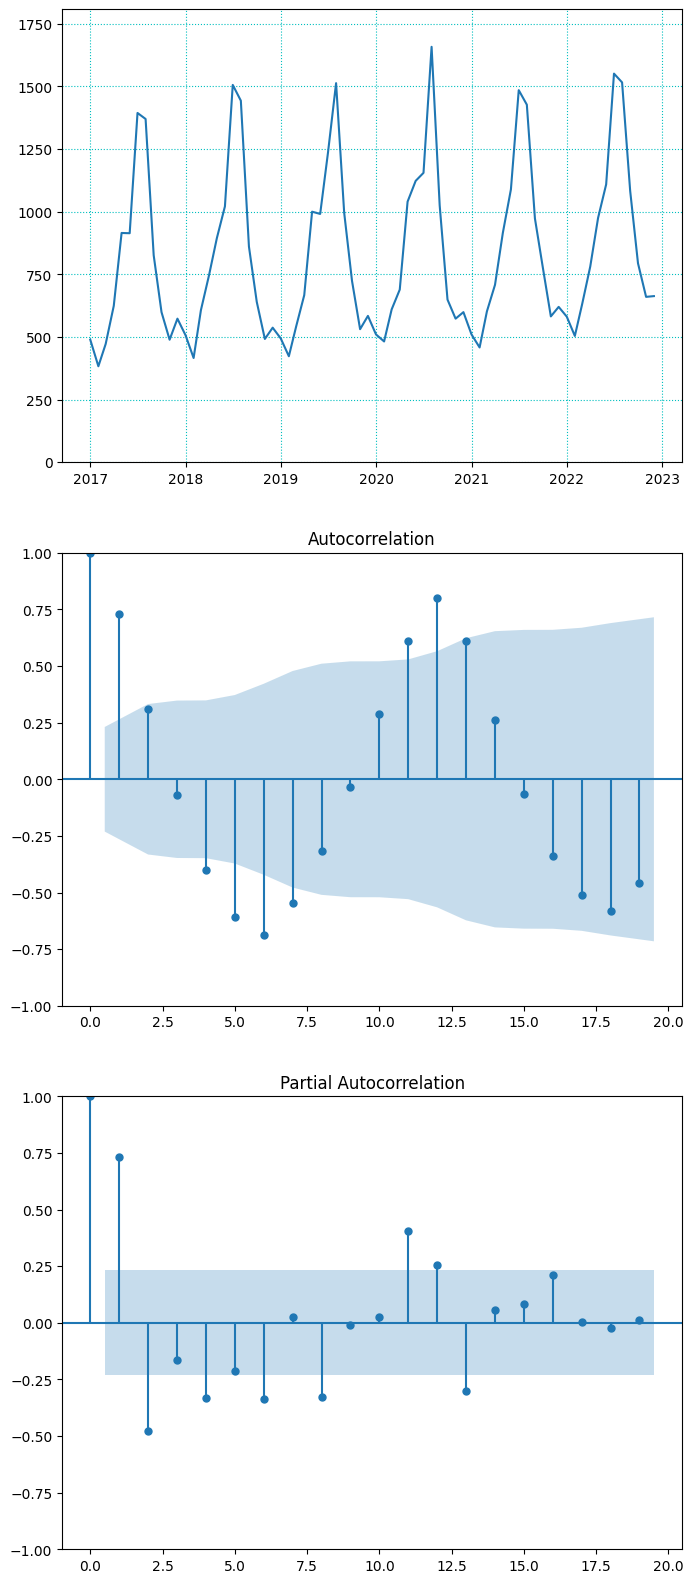

In [24]:
# アイスクリーム売上のグラフを表示
fig = plt.figure(figsize=(8, 20))  
ax = fig.add_subplot(311)
ax.plot(icecream_df)
y_min, y_max = ax.get_ylim()
ax.set_ylim(0, y_max * 1.05)
ax.grid(axis='both',linestyle='dotted', color='c')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 

# 自己相関係数と偏自己相関係数のグラフを表示
ax1 = fig.add_subplot(312)
fig = sm.graphics.tsa.plot_acf(icecream_df, ax=ax1)
ax2 = fig.add_subplot(313)
fig = sm.graphics.tsa.plot_pacf(icecream_df, ax=ax2, method='ywm')

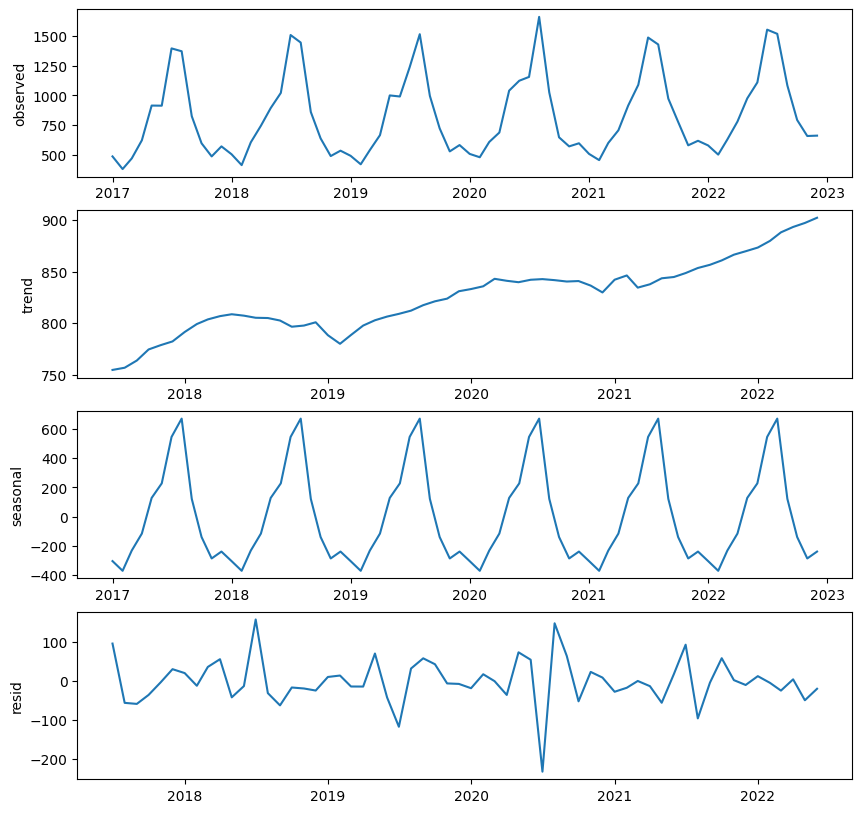

In [25]:
# 時系列データをトレンド、規則的変動成分、不規則変動成分に分解
res = sm.tsa.seasonal_decompose(icecream_df, period=12)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(411)
ax1.set_ylabel('observed')
ax1.plot(res.observed)
ax2 = fig.add_subplot(412)
ax2.set_ylabel('trend')
ax2.plot(res.trend)
ax3 = fig.add_subplot(413)
ax3.set_ylabel('seasonal')
ax3.plot(res.seasonal)
ax4 = fig.add_subplot(414)
ax4.set_ylabel('resid')
ax4.plot(res.resid)


In [26]:
# モデル構築と検証のためのデータを準備
train = icecream_df[0:60]  # 学習用データ 2021年まで
test = icecream_df[60:]  # 検証用データ 2022年分

In [27]:
# グリッドサーチで最適なARIMAモデルを探索
p = d = q = range(0, 2) # パラメータ範囲の設定
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] 

best_aic = np.inf # 最小AICを無限大で初期化
best_params = None # 最適なパラメータを格納する変数
# グリッドサーチを実行
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.SARIMAX(train, order=param, seasonal_order=seasonal_param,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
            results = model.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
                print(f"New best AIC: {best_aic} with params {best_params}")
        except:
            continue

print(f"Best SARIMAX parameters: {best_params}")

New best AIC: 969.8485030577707 with params ((0, 0, 0), (0, 0, 0, 12))
New best AIC: 733.5679294720587 with params ((0, 0, 0), (0, 0, 1, 12))
New best AIC: 567.4473415230514 with params ((0, 0, 0), (0, 1, 0, 12))
New best AIC: 559.3501495124955 with params ((0, 0, 0), (1, 0, 1, 12))
New best AIC: 437.44779923337626 with params ((0, 0, 0), (1, 1, 0, 12))
New best AIC: 436.78795870426865 with params ((0, 0, 1), (1, 1, 0, 12))
New best AIC: 429.33819006366207 with params ((0, 1, 1), (1, 1, 0, 12))
New best AIC: 427.0048968403218 with params ((1, 0, 0), (1, 1, 0, 12))
New best AIC: 417.2367895682781 with params ((1, 1, 1), (1, 1, 0, 12))
Best SARIMAX parameters: ((1, 1, 1), (1, 1, 0, 12))


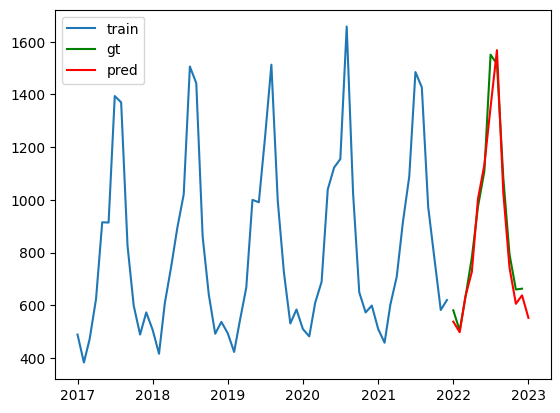

In [28]:
# 最適なパラメータでモデルを構築し、予測を実施
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
SARIMA = sm.tsa.SARIMAX(train.earning, order=best_params[0], seasonal_order=best_params[1],
                     enforce_stationarity=False, enforce_invertibility=False).fit()
pred = SARIMA.predict('2022-01-01', '2023-01-01')
# 実データと予測結果の図示
plt.plot(train.earning, label="train")
plt.plot(test.earning, "g", label="gt")
plt.plot(pred, "r", label="pred")
plt.legend()